# Dependencies

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import MiniBatchNMF

In [17]:
ratings = pd.read_csv("../data/movielens/ratings.csv")

# Preprocessing

In [18]:
ratings = ratings.drop(columns="timestamp")
ratings.head(2)

,user_id,movie_id,rating
0,1,1,4.0
1,1,110,4.0


In [19]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = ratings["rating"].shape[0]

print(f"There are {n_users} users in the dataset.")
print(f"There are {n_movies} movies in the dataset.")
print(f"There are {n_ratings} ratings in the dataset.")

There are 330975 users in the dataset.
There are 83239 movies in the dataset.
There are 33832162 ratings in the dataset.


## Filtering

In [20]:
# Finding stats on user ratings
ratings_per_user = ratings.groupby("user_id").size()
print(f"Average ratings per user: {ratings_per_user.mean():.2f}")
print(f"Median ratings per user: {ratings_per_user.median():.2f}")
print(f"Min ratings: {ratings_per_user.min()}")
print(f"Max ratings: {ratings_per_user.max()}")
print()
mean_user_rating = ratings_per_user.mean()

# Filtering out users with less than the average number of ratings
user_rating_counts = ratings["user_id"].value_counts()
average_users = user_rating_counts[user_rating_counts >= mean_user_rating].index
filtered_ratings = ratings[ratings["user_id"].isin(average_users)]

# Reviewing the filtered dataset
n_users_filtered = filtered_ratings["user_id"].nunique()
print(f"There are now {n_users_filtered} users in the dataset. {n_users_filtered / n_users:.2%} of the original dataset.")

Average ratings per user: 102.22
Median ratings per user: 31.00
Min ratings: 1
Max ratings: 33332

There are now 79469 users in the dataset. 24.01% of the original dataset.


In [21]:
# Finding stats on movie ratings
ratings_per_movie = ratings.groupby("movie_id").size()
print(f"Average ratings per movie: {ratings_per_movie.mean():.2f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.2f}")
print(f"Min ratings: {ratings_per_movie.min()}")
print(f"Max ratings: {ratings_per_movie.max()}")
print()

# Filtering out movies with less than the average number of ratings
movie_rating_counts = ratings["movie_id"].value_counts()
average_movies = movie_rating_counts[movie_rating_counts >= 25].index
filtered_ratings = filtered_ratings[filtered_ratings["movie_id"].isin(average_movies)]

# Reviewing the filtered dataset
n_movies_filtered = filtered_ratings["movie_id"].nunique()
print(f"There are now {n_movies_filtered} movies in the dataset. {n_movies_filtered / n_movies:.2%} of the original dataset.")

Average ratings per movie: 406.45
Median ratings per movie: 5.00
Min ratings: 1
Max ratings: 122296

There are now 21297 movies in the dataset. 25.59% of the original dataset.


In [22]:
ratings = filtered_ratings

## Standardising user ratings

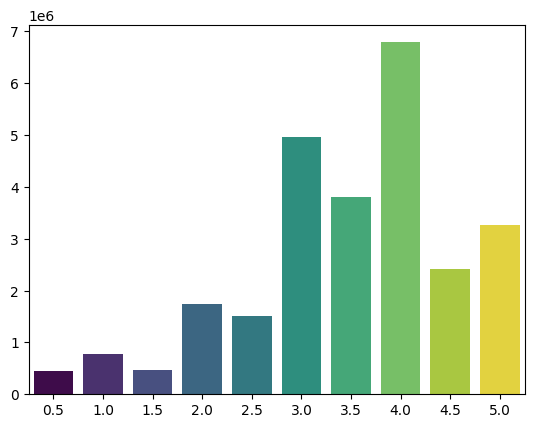

In [23]:
# Visualising the rating distribution
rating_distribution = ratings["rating"].value_counts().to_dict()
rating_distribution = dict(sorted(rating_distribution.items()))
sns.barplot(x=list(rating_distribution.keys()), y=list(rating_distribution.values()), hue=list(rating_distribution.keys()), palette="viridis", legend=False);

In [24]:
# # Standardising with epsilon to prevent NaNs
# ratings["rating"] = ratings.groupby("user_id")["rating"].transform(lambda x: (x - x.mean()) / (x.std() + 1e-5))

# # Normalising to positive values for NMF
# ratings["rating"] = ratings.groupby("user_id")["rating"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [ ]:
scaled_ratings = ratings.copy()
users_groupby = scaled_ratings.groupby("user_id")

# Standardising with epsilon to prevent NaNs
scaled_ratings["rating"] = users_groupby["rating"].transform(lambda x: (x - x.mean()) / (x.std() + 1e-2))

# Normalising to positive values for NMF
scaled_ratings["rating"] = users_groupby["rating"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

In [ ]:
print(np.isnan(scaled_ratings).any())
print()
print(np.isnan(scaled_ratings).sum())

user_id     False
movie_id    False
rating       True
dtype: bool

user_id         0
movie_id        0
rating      10233
dtype: int64


In [27]:
ratings = scaled_ratings

In [28]:
ratings.head(2)

,user_id,movie_id,rating
304,7,1,0.666667
305,7,3,0.333333


In [29]:
print(np.isnan(ratings).any())
print()
print(np.isnan(ratings).sum())

user_id     False
movie_id    False
rating       True
dtype: bool

user_id         0
movie_id        0
rating      10233
dtype: int64


## Matrix creation

In [30]:
# Create sparse matrix
user_values = ratings["user_id"].values
movie_values = ratings["movie_id"].values
rating_values = ratings["rating"].values

# Create mappings for row/column indices
user_mapper = {user: i for i, user in enumerate(np.unique(user_values))}
movie_mapper = {movie: i for i, movie in enumerate(np.unique(movie_values))}

# Map to matrix indices
user_indices = np.array([user_mapper[user] for user in user_values])
movie_indices = np.array([movie_mapper[movie] for movie in movie_values])

# Create the sparse matrix
rating_matrix = csr_matrix((rating_values, (user_indices, movie_indices)))

In [31]:
density = rating_matrix.nnz / (rating_matrix.shape[0] * rating_matrix.shape[1])
print(f"Density of the rating matrix: {density * 100:.3f} %")

Density of the rating matrix: 1.547 %


In [32]:
rating_matrix.shape

(79469, 21297)

# Matrix factorisation

In [33]:
n = 20
b = 1000
aW = 0.1
aH = 0.1
m = 150

# # Replace NaN values in the rating matrix with zeros
# rating_matrix = rating_matrix.copy()
# rating_matrix.data = np.nan_to_num(rating_matrix.data)

nmf = MiniBatchNMF(n_components=n)#, batch_size=b, alpha_W=aW, alpha_H=aH, max_iter=m)
W = nmf.fit_transform(rating_matrix)
H = nmf.components_
print(f"Shape of W: {W.shape}")
print(f"Shape of H: {H.shape}")

ValueError: Input X contains NaN.
MiniBatchNMF does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values